In [1]:
%load_ext autoreload
%autoreload 2

from src.util import load_coauthor_nx, ddir, fn_nodes, fn_statoids

import community
import networkx as nx
from operator import itemgetter
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import skbio.diversity.alpha as b

In [2]:
(G, nodes) = load_coauthor_nx() # abstracted into src

N nodes 361 ; N not nodes: 368
Proportion who did not coauthor 50.48010973936899
Name: 
Type: Graph
Number of nodes: 361
Number of edges: 463
Average degree:   2.5651


## Communities

In [3]:
nodes_df = pd.read_csv(fn_nodes)
statoids = pd.read_csv(fn_statoids)
statoids = area_dict = dict(zip(statoids.DL, statoids.Country))

fn_spp = ddir + '2019-05-23-Apoidea world consensus file Sorted by name 2019 describers_2.0-denormalised.csv'
spp = pd.read_csv(fn_spp)[["idx", "full.name.of.describer.n"]]
spp = spp[spp.duplicated(subset="idx", keep=False)] # keep only those with >1 authors

In [4]:
communities = community.best_partition(G)  # https://python-louvain.readthedocs.io/en/latest/api.html
nx.set_node_attributes(G, communities, 'modularity')

class0 = [n for n in G.nodes() if G.nodes[n]['modularity'] == 0]; len(class0)

# Then create a dictionary of the eigenvector centralities of those nodes
class0_eigenvector = {n:G.nodes[n]['eigenvector'] for n in class0}

# Then sort that dictionary and print the first 5 results
class0_sorted_by_eigenvector = sorted(class0_eigenvector.items(), key=itemgetter(1), reverse=True)
print("Modularity Class 0 Sorted by Eigenvector Centrality:")
for node in class0_sorted_by_eigenvector[:10]:
    print("Name:", node[0], "| Eigenvector Centrality:", node[1])

Modularity Class 0 Sorted by Eigenvector Centrality:
Name: Michael Scott Engel | Eigenvector Centrality: 0.4607013143210458
Name: Terry L. Griswold | Eigenvector Centrality: 0.32146051380748536
Name: Victor Hugo Gonzalez [Betancourt] | Eigenvector Centrality: 0.29420394689460644
Name: Ricardo Ayala Barajas | Eigenvector Centrality: 0.19620102130148936
Name: Ismael Alejandro Hinojosa-Díaz | Eigenvector Centrality: 0.1845644245423236
Name: John Stoskopf Ascher | Eigenvector Centrality: 0.1697520309963212
Name: Molly Greer Rightmyer | Eigenvector Centrality: 0.14119439831030106
Name: Mark Amidon Deyrup | Eigenvector Centrality: 0.12334089443215683
Name: Allan Henry Smith-Pardo | Eigenvector Centrality: 0.10826750398308012
Name: Abdulaziz S. Alqarni | Eigenvector Centrality: 0.1074778533950178


In [5]:
modularity = {}                            # Create a new, empty dictionary

for k, v in communities.items():           # Loop through the community dictionary
    if v not in modularity:
        modularity[v] = [k]                # Add a new key for a modularity class the code hasn't seen before
    else:
        modularity[v].append(k)            # Append a name to the list for a modularity class the code has already seen

countries = {}
counter = 0
for k, v in modularity.items():            # Loop through the new dictionary
    counter = counter + len(v)
    country_li = []
    for i in range(0, len(v)):
        country = nodes_df[nodes_df['full.name.of.describer.n'] == v[i]]['residence.country.describer.n'].values[0]
        country = str.split(country, "; ")
        country_li = country_li + country
    countries[k] = Counter(country_li)

print("\n", counter, " authors/ nodes")


 361  authors/ nodes


In [6]:
len(modularity)-41 # includes  subgraphs which are N=42

12

In [7]:
subgraphs = [c for c in sorted(nx.connected_components(G), key=len, reverse=True)]

def get_subgraph(node_name):
    subgraph_idx = -1
    
    for i in range(0, len(subgraphs)):
        if (node_name in list(subgraphs[i])):
            subgraph_idx = i
    
    return subgraph_idx
          
community_subgraph = pd.DataFrame.from_dict({key:get_subgraph(value[0]) for (key,value) in modularity.items()}, orient='index')

In [8]:
len(modularity)

53

In [9]:
N_species = {}
for i, sg in enumerate(modularity.items()):
    spp_li = []
    for auth in sg[1]:
        spp_li = spp_li + list(spp[spp['full.name.of.describer.n']==auth]['idx'].values)
        
    N_species[i] = len(set(spp_li))
N_species = pd.DataFrame.from_dict(N_species, orient="index")
N_species.columns = ["N_species"]

In [10]:
countries_df = pd.DataFrame.from_dict(countries, orient='index')
cols = list(countries_df.columns.values) 
cols.pop(cols.index('[unknown]'))
cols_rearranged = cols + ['[unknown]']
countries_df = countries_df[cols_rearranged]
countries_df = countries_df.sort_index()
countries_df = countries_df.fillna(0)

In [11]:
countries_summary = countries_df.stack().reset_index()

# count number of countries, count number of taxonomist
countries_summary1 = countries_summary[countries_summary[0] > 0].groupby("level_0").agg({0: ['count']})
countries_summary2 = countries_summary.groupby("level_0").agg({0: ['sum']})
countries_summary = countries_summary1.merge(countries_summary2, "outer", left_index=True, right_index=True)

countries_summary = countries_summary.merge(community_subgraph, "outer", left_index=True, right_index=True)
countries_summary = countries_summary.merge(N_species, "outer", left_index=True, right_index=True)

countries_summary.columns = ['N_countries', 'N_taxonomist', 'Subgraph_id', 'N_species']
countries_summary.index.names = ['Modules']
countries_summary = countries_summary.sort_values(['Subgraph_id', 'N_taxonomist'], ascending=[True,  False])
countries_summary['idx'] = range(0, len(countries_summary))
countries['lab'] = ' [' + countries_summary['N_taxonomist'].astype(int).astype(str) + ',' +\
    countries_summary['N_countries'].astype(int).astype(str) + "," +\
    countries_summary['N_species'].astype(int).astype(str) + '] ' +\
    "id" + countries_summary.idx.astype(str).str.pad(2, "left", "0") + " / " +\
    "S" + countries_summary['Subgraph_id'].astype(str).str.pad(2, "left", "0")
    
countries_summary = countries_summary.sort_index()
idx = countries_summary.idx.values
countries_summary = countries_summary.sort_values(['Subgraph_id', 'N_taxonomist'], ascending=[True,  False])

/home/ejysoh/miniconda3/envs/msc/lib/python3.7/site-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [12]:
countries_summary.agg({'N_countries': ['median', 'min', 'max'],
                       'N_taxonomist': ['median', 'min', 'max']})

,N_countries,N_taxonomist
median,1.0,2.0
min,1.0,2.0
max,13.0,46.0


In [13]:
countries_summary.groupby('Subgraph_id')\
                 .agg({'N_countries': ['median', 'min', 'max', 'count'],
                       'N_taxonomist': ['median', 'min', 'max']}).iloc[0] # for subgraph 1

N_countries   median     7.0
              min        2.0
              max       13.0
              count     12.0
N_taxonomist  median    19.0
              min        2.0
              max       46.0
Name: 0, dtype: float64

All of the subgraphs only have one cluster, but the largest one has 12 clusters.

In [14]:
countries_prop = countries_df.apply(lambda r: round(r/r.sum()*100, 1), axis=1)
countries_prop.index = idx
countries_prop = countries_prop.sort_index()
countries_prop.index = countries['lab']

In [15]:
def parse_countries(country):
    if country == "[unknown]":
        return country
    else:
        return statoids[country]
countries_prop.columns = [parse_countries(x) for x in countries_prop.columns]
countries_prop.columns = countries_prop.columns + " [" + countries_prop.count().astype(str) + "]"

[Text(113.99999999999999, 0.5, 'Countries'),
 Text(0.5, 96.0, '\nProportion of country from each module (%)')]

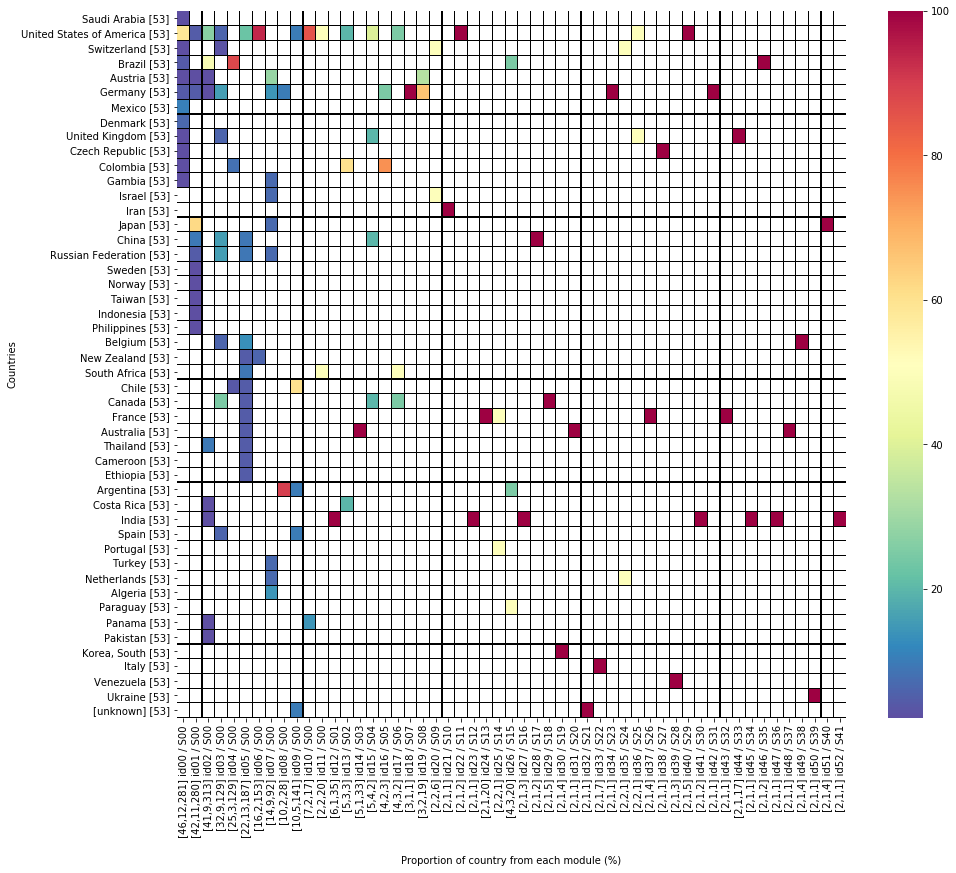

In [16]:
countries_prop_t = countries_prop.transpose(copy=True)
countries_prop_t[countries_prop_t.columns] = countries_prop_t[countries_prop_t.columns].replace({0: float('nan')})
plt.figure(figsize=(15, 13))
ax = sns.heatmap(countries_prop_t, cmap=plt.get_cmap("Spectral_r"), linecolor="k", linewidths=0.1)
ax.set(xlabel='\nProportion of country from each module (%)', ylabel='Countries')

In [17]:
countries_prop.iloc[2][countries_prop.iloc[2] != 0]

United States of America [53]    26.8
Brazil [53]                      48.8
Austria [53]                      2.4
Germany [53]                      2.4
Thailand [53]                     9.8
Costa Rica [53]                   2.4
India [53]                        2.4
Panama [53]                       2.4
Pakistan [53]                     2.4
Name:  [41,9,313] id02 / S00, dtype: float64

In [18]:
countries_prop.iloc[2][countries_prop.iloc[2] != 0]

United States of America [53]    26.8
Brazil [53]                      48.8
Austria [53]                      2.4
Germany [53]                      2.4
Thailand [53]                     9.8
Costa Rica [53]                   2.4
India [53]                        2.4
Panama [53]                       2.4
Pakistan [53]                     2.4
Name:  [41,9,313] id02 / S00, dtype: float64

In [19]:
indices_simpsons = []
indices_shannon = []

for i, idx in enumerate(countries_prop.index):
    country_counts = countries_prop.iloc[i].values
    
#     indices = countries_prop.iloc[i][countries_prop.iloc[i].notna()].values
    indices_simpsons =  indices_simpsons + [b.simpson(country_counts)]
    indices_shannon =  indices_shannon + [b.shannon(country_counts)]

In [20]:
countries_summary['simpson'] = indices_simpsons
countries_summary['shannon'] = indices_shannon

countries_summary

,N_countries,N_taxonomist,Subgraph_id,N_species,idx,simpson,shannon
Modules,,,,,,,
0,12,46.0,0,281,0,0.632973,2.293537
3,11,42.0,0,280,1,0.599051,2.155209
19,9,41.0,0,313,2,0.675676,2.118820
11,9,32.0,0,129,3,0.847240,2.909057
9,3,25.0,0,129,4,0.217600,0.639556
4,13,22.0,0,187,5,0.888038,3.439704
10,2,16.0,0,153,6,0.116312,0.335334
16,9,14.0,0,92,7,0.846446,2.947627
6,2,10.0,0,28,8,0.180000,0.468996


[Text(0, 0.5, 'Number of taxonomists'), Text(0.5, 0, '\n Number of countries')]

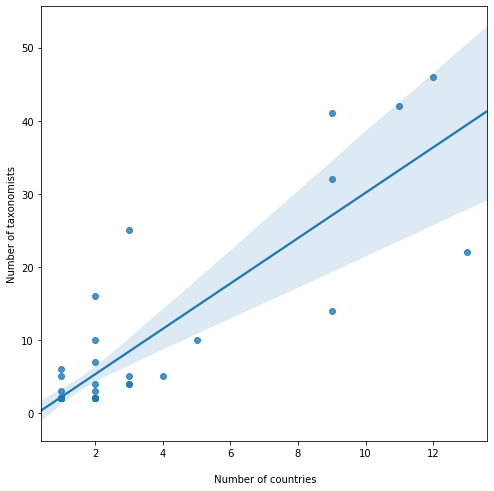

In [33]:
plt.figure(figsize=(8, 8))
ax = sns.regplot(countries_summary['N_countries'], countries_summary['N_taxonomist'])
ax.set(xlabel='\n Number of countries', 
       ylabel='Number of taxonomists')